In [ ]:
# necessary files to import.....
import numpy as np
from termcolor import colored

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Dense


# Compare the two inputs
def comparator(learner, instructor):
    if learner == instructor:
        for a, b in zip(learner, instructor):
            if tuple(a) != tuple(b):
                print(colored("Test failed", attrs=['bold']),
                      "\n Expected value \n\n", colored(f"{b}", "green"), 
                      "\n\n does not match the input value: \n\n", 
                      colored(f"{a}", "red"))
                raise AssertionError("Error in test") 
        print(colored("All tests passed!", "green"))
        
    else:
        print(colored("Test failed. Your output is not as expected output.", "red"))

# extracts the description of a given model
def summary(model):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    result = []
    for layer in model.layers:
        descriptors = [layer.__class__.__name__, layer.output_shape, layer.count_params()]
        if (type(layer) == Conv2D):
            descriptors.append(layer.padding)
            descriptors.append(layer.activation.__name__)
            descriptors.append(layer.kernel_initializer.__class__.__name__)
        if (type(layer) == MaxPooling2D):
            descriptors.append(layer.pool_size)
            descriptors.append(layer.strides)
            descriptors.append(layer.padding)
        if (type(layer) == Dropout):
            descriptors.append(layer.rate)
        if (type(layer) == ZeroPadding2D):
            descriptors.append(layer.padding)
        if (type(layer) == Dense):
            descriptors.append(layer.activation.__name__)
        result.append(descriptors)
    return result

def datatype_check(expected_output, target_output, error):
    success = 0
    if isinstance(target_output, dict):
        for key in target_output.keys():
            try:
                success += datatype_check(expected_output[key], 
                                         target_output[key], error)
            except:
                print("Error: {} in variable {}. Got {} but expected type {}".format(error,
                                                                          key, type(target_output[key]), type(expected_output[key])))
        if success == len(target_output.keys()):
            return 1
        else:
            return 0
    elif isinstance(target_output, tuple) or isinstance(target_output, list):
        for i in range(len(target_output)):
            try: 
                success += datatype_check(expected_output[i], 
                                         target_output[i], error)
            except:
                print("Error: {} in variable {}, expected type: {}  but expected type {}".format(error,
                                                                          i, type(target_output[i]), type(expected_output[i])))
        if success == len(target_output):
            return 1
        else:
            return 0
                
    else:
        assert isinstance(target_output, type(expected_output))
        return 1
            
def equation_output_check(expected_output, target_output, error):
    success = 0
    if isinstance(target_output, dict):
        for key in target_output.keys():
            try:
                success += equation_output_check(expected_output[key], 
                                         target_output[key], error)
            except:
                print("Error: {} for variable {}.".format(error,
                                                                          key))
        if success == len(target_output.keys()):
            return 1
        else:
            return 0
    elif isinstance(target_output, tuple) or isinstance(target_output, list):
        for i in range(len(target_output)):
            try: 
                success += equation_output_check(expected_output[i], 
                                         target_output[i], error)
            except:
                print("Error: {} for variable in position {}.".format(error, i))
        if success == len(target_output):
            return 1
        else:
            return 0
                
    else:
        if hasattr(target_output, 'shape'):
            np.testing.assert_array_almost_equal(target_output, expected_output)
        else:
            assert target_output == expected_output
        return 1
    
def shape_check(expected_output, target_output, error):
    success = 0
    if isinstance(target_output, dict):
        for key in target_output.keys():
            try:
                success += shape_check(expected_output[key], 
                                         target_output[key], error)
            except:
                print("Error: {} for variable {}.".format(error, key))
        if success == len(target_output.keys()):
            return 1
        else:
            return 0
    elif isinstance(target_output, tuple) or isinstance(target_output, list):
        for i in range(len(target_output)):
            try: 
                success += shape_check(expected_output[i], 
                                         target_output[i], error)
            except:
                print("Error: {} for variable {}.".format(error, i))
        if success == len(target_output):
            return 1
        else:
            return 0
                
    else:
        if hasattr(target_output, 'shape'):
            assert target_output.shape == expected_output.shape
        return 1
                
def single_test(test_cases, target):
    success = 0
    for test_case in test_cases:
        try:
            if test_case['name'] == "datatype_check":
                assert isinstance(target(*test_case['input']),
                                  type(test_case["expected"]))
                success += 1
            if test_case['name'] == "equation_output_check":
                assert np.allclose(test_case["expected"],
                                   target(*test_case['input']))
                success += 1
            if test_case['name'] == "shape_check":
                assert test_case['expected'].shape == target(*test_case['input']).shape
                success += 1
        except:
            print("Error: " + test_case['error'])
            
    if success == len(test_cases):
        print("\033[92m All tests passed.")
    else:
        print('\033[92m', success," Tests passed")
        print('\033[91m', len(test_cases) - success, " Tests failed")
        raise AssertionError("Not all tests were passed for {}. Check your equations and avoid using global variables inside the function.".format(target.__name__))
        
def multiple_test(test_cases, target):
    success = 0
    for test_case in test_cases:
        try:
            target_answer = target(*test_case['input'])                   
            if test_case['name'] == "datatype_check":
                success += datatype_check(test_case['expected'], target_answer, test_case['error'])
            if test_case['name'] == "equation_output_check":
                success += equation_output_check(test_case['expected'], target_answer, test_case['error'])
            if test_case['name'] == "shape_check":
                success += shape_check(test_case['expected'], target_answer, test_case['error'])
        except:
            print("Error: " + test_case['error'])
            
    if success == len(test_cases):
        print("\033[92m All tests passed.")
    else:
        print('\033[92m', success," Tests passed")
        print('\033[91m', len(test_cases) - success, " Tests failed")
        raise AssertionError("Not all tests were passed for {}. Check your equations and avoid using global variables inside the function.".format(target.__name__))
        
        
        


In [ ]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops


def load_happy_dataset():
    train_dataset = h5py.File('dataset_path/train_happy.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('dataset_path/test_happy.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

def load_signs_dataset():
    train_dataset = h5py.File('dataset_path/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('dataset_path/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

def random_mini_batches(X, Y, mini_batch_size=64, seed=0):
    """
    Creates a list of random minibatches from (X, Y)

    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.

    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """

    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)

    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :, :, :]
    shuffled_Y = Y[permutation, :]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    # number of mini batches of size mini_batch_size in your partitionning
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size: k *
                                  mini_batch_size + mini_batch_size, :, :, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size: k *
                                  mini_batch_size + mini_batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches *
                                  mini_batch_size: m, :, :, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches *
                                  mini_batch_size: m, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches


def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y


def forward_propagation_for_predict(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX

    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """

    # Retrieve the parameters from the dictionary "parameters"
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    # Numpy Equivalents:
    # Z1 = np.dot(W1, X) + b1
    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    # Z2 = np.dot(W2, a1) + b2
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    # Z3 = np.dot(W3,Z2) + b3
    Z3 = tf.add(tf.matmul(W3, A2), b3)

    return Z3


def predict(X, parameters):

    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])

    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}

    x = tf.placeholder("float", [12288, 1])

    z3 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z3)

    sess = tf.Session()
    prediction = sess.run(p, feed_dict={x: X})

    return prediction

# def predict(X, parameters):
#
#    W1 = tf.convert_to_tensor(parameters["W1"])
#    b1 = tf.convert_to_tensor(parameters["b1"])
#    W2 = tf.convert_to_tensor(parameters["W2"])
#    b2 = tf.convert_to_tensor(parameters["b2"])
##    W3 = tf.convert_to_tensor(parameters["W3"])
##    b3 = tf.convert_to_tensor(parameters["b3"])
#
# params = {"W1": W1,
# "b1": b1,
# "W2": W2,
# "b2": b2,
# "W3": W3,
# "b3": b3}
#
#    params = {"W1": W1,
#              "b1": b1,
#              "W2": W2,
#              "b2": b2}
#
#    x = tf.placeholder("float", [12288, 1])
#
#    z3 = forward_propagation(x, params)
#    p = tf.argmax(z3)
#
#    with tf.Session() as sess:
#        prediction = sess.run(p, feed_dict = {x: X})
#
#    return prediction


In [ ]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops

%matplotlib inline
np.random.seed(1)

In [ ]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_happy_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


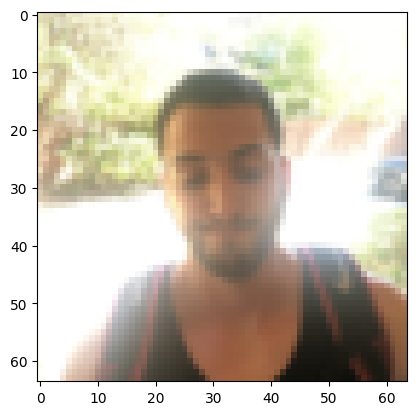

In [ ]:
index = 124
plt.imshow(X_train_orig[index]) #display sample training image
plt.show()

In [ ]:
# GRADED FUNCTION: happyModel

def happyModel():
    """
    Implements the forward propagation for the binary classification model:
    ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
    Note that for simplicity and grading purposes, you'll hard-code all the values
    such as the stride and kernel (filter) sizes. 
    Normally, functions should take these values as function parameters.
    
    Arguments:
    None

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """
    model = tf.keras.Sequential([
            tf.keras.Input(shape=(64 , 64 ,3)),
            ## ZeroPadding2D with padding 3, input shape of 64 x 64 x 3
            tfl.ZeroPadding2D(padding=3),
            ## Conv2D with 32 7x7 filters and stride of 1
            tfl.Conv2D(filters=32,kernel_size=7,strides=1),
            ## BatchNormalization for axis 3
            tfl.BatchNormalization(axis=3, momentum=0.99, epsilon=0.001),
            ## ReLU
            tfl.ReLU(),
            ## Max Pooling 2D with default parameters
            tfl.MaxPool2D(),
            ## Flatten layer
             tfl.Flatten(),
            ## Dense layer with 1 unit for output & 'sigmoid' activation
            tfl.Dense(1,activation='sigmoid')
            # YOUR CODE STARTS HERE
            
            
            # YOUR CODE ENDS HERE
        ])
    
    return model

In [ ]:
happy_model = happyModel()
# Print a summary for each layer
for layer in summary(happy_model):
    print(layer)
    
output = [['ZeroPadding2D', (None, 70, 70, 3), 0, ((3, 3), (3, 3))],
            ['Conv2D', (None, 64, 64, 32), 4736, 'valid', 'linear', 'GlorotUniform'],
            ['BatchNormalization', (None, 64, 64, 32), 128],
            ['ReLU', (None, 64, 64, 32), 0],
            ['MaxPooling2D', (None, 32, 32, 32), 0, (2, 2), (2, 2), 'valid'],
            ['Flatten', (None, 32768), 0],
            ['Dense', (None, 1), 32769, 'sigmoid']]
    
comparator(summary(happy_model), output)

['ZeroPadding2D', (None, 70, 70, 3), 0, ((3, 3), (3, 3))]
['Conv2D', (None, 64, 64, 32), 4736, 'valid', 'linear', 'GlorotUniform']
['BatchNormalization', (None, 64, 64, 32), 128]
['ReLU', (None, 64, 64, 32), 0]
['MaxPooling2D', (None, 32, 32, 32), 0, (2, 2), (2, 2), 'valid']
['Flatten', (None, 32768), 0]
['Dense', (None, 1), 32769, 'sigmoid']
All tests passed!


In [ ]:
happy_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [ ]:
happy_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 70, 70, 3)        0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        4736      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                        

In [ ]:
happy_model.fit(X_train, Y_train, epochs=15, batch_size=16)

Epoch 1/15
38/38 [==============================] - 6s 121ms/step - loss: 1.9561 - accuracy: 0.6367
Epoch 2/15
38/38 [==============================] - 7s 189ms/step - loss: 0.2446 - accuracy: 0.9017
Epoch 3/15
38/38 [==============================] - 4s 113ms/step - loss: 0.1484 - accuracy: 0.9517
Epoch 4/15
38/38 [==============================] - 5s 143ms/step - loss: 0.1550 - accuracy: 0.9400
Epoch 5/15
38/38 [==============================] - 6s 145ms/step - loss: 0.1142 - accuracy: 0.9683
Epoch 6/15
38/38 [==============================] - 5s 130ms/step - loss: 0.1118 - accuracy: 0.9600
Epoch 7/15
38/38 [==============================] - 7s 178ms/step - loss: 0.1536 - accuracy: 0.9450
Epoch 8/15
38/38 [==============================] - 8s 214ms/step - loss: 0.0842 - accuracy: 0.9717
Epoch 9/15
38/38 [==============================] - 4s 114ms/step - loss: 0.0894 - accuracy: 0.9700
Epoch 10/15
38/38 [==============================] - 6s 150ms/step - loss: 0.0661 - accuracy: 0.9817

In [ ]:
happy_model.evaluate(X_test, Y_test)

5/5 [==============================] - 0s 59ms/step - loss: 0.3209 - accuracy: 0.8800


[0.32089731097221375, 0.8799999952316284]

In [ ]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_signs_dataset()

y = 4


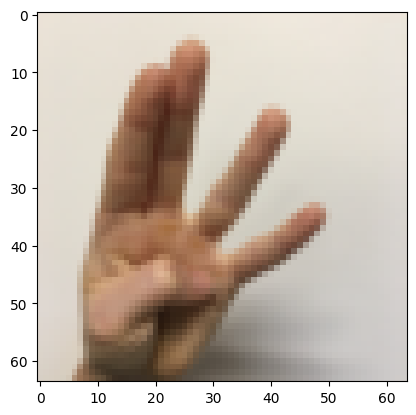

In [ ]:
# Example of an image from the dataset
index = 9
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [ ]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [ ]:
# GRADED FUNCTION: convolutional_model

def convolutional_model(input_shape):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
    Note that for simplicity and grading purposes, you'll hard-code some values
    such as the stride and kernel (filter) sizes. 
    Normally, functions should take these values as function parameters.
    
    Arguments:
    input_img -- input dataset, of shape (input_shape)

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """

    input_img = tf.keras.Input(shape=input_shape)
    ## CONV2D: 8 filters 4x4, stride of 1, padding 'SAME'
    Z1 = tfl.Conv2D(filters= 8. , kernel_size=4 , padding='same',strides=1)(input_img)
    ## RELU
    A1 = tfl.ReLU()(Z1)
    ## MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tfl.MaxPool2D(pool_size=8, strides=8, padding='SAME')(A1)
    ## CONV2D: 16 filters 2x2, stride 1, padding 'SAME'
    Z2 = tfl.Conv2D(filters= 16. , kernel_size=2 , padding='same',strides=1)(P1)
    ## RELU
    A2 = tfl.ReLU()(Z2)
    ## MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tfl.MaxPool2D(pool_size=4, strides=4, padding='SAME')(A2)
    ## FLATTEN
    F = tfl.Flatten()(P2)
    ## Dense layer
    ## 6 neurons in output layer. Hint: one of the arguments should be "activation='softmax'" 
    outputs = tfl.Dense(units= 6 , activation='softmax')(F)
    # YOUR CODE STARTS HERE
    
    
    # YOUR CODE ENDS HERE
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [ ]:
conv_model = convolutional_model((64, 64, 3))
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()
    
output = [['InputLayer', [(None, 64, 64, 3)], 0],
        ['Conv2D', (None, 64, 64, 8), 392, 'same', 'linear', 'GlorotUniform'],
        ['ReLU', (None, 64, 64, 8), 0],
        ['MaxPooling2D', (None, 8, 8, 8), 0, (8, 8), (8, 8), 'same'],
        ['Conv2D', (None, 8, 8, 16), 528, 'same', 'linear', 'GlorotUniform'],
        ['ReLU', (None, 8, 8, 16), 0],
        ['MaxPooling2D', (None, 2, 2, 16), 0, (4, 4), (4, 4), 'same'],
        ['Flatten', (None, 64), 0],
        ['Dense', (None, 6), 390, 'softmax']]
    
comparator(summary(conv_model), output)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 8)         392       
                                                                 
 re_lu_1 (ReLU)              (None, 64, 64, 8)         0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 16)          528       
                                                                 
 re_lu_2 (ReLU)              (None, 8, 8, 16)          0         
                                                             

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)
history = conv_model.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
17/17 [==============================] - 5s 181ms/step - loss: 1.8044 - accuracy: 0.1806 - val_loss: 1.7880 - val_accuracy: 0.1833
Epoch 2/100
17/17 [==============================] - 2s 125ms/step - loss: 1.7870 - accuracy: 0.2130 - val_loss: 1.7851 - val_accuracy: 0.2417
Epoch 3/100
17/17 [==============================] - 6s 333ms/step - loss: 1.7833 - accuracy: 0.2231 - val_loss: 1.7809 - val_accuracy: 0.2167
Epoch 4/100
17/17 [==============================] - 2s 125ms/step - loss: 1.7798 - accuracy: 0.2472 - val_loss: 1.7770 - val_accuracy: 0.2333
Epoch 5/100
17/17 [==============================] - 2s 121ms/step - loss: 1.7763 - accuracy: 0.2796 - val_loss: 1.7735 - val_accuracy: 0.2417
Epoch 6/100
17/17 [==============================] - 3s 196ms/step - loss: 1.7719 - accuracy: 0.2815 - val_loss: 1.7675 - val_accuracy: 0.3083
Epoch 7/100
17/17 [==============================] - 4s 220ms/step - loss: 1.7656 - accuracy: 0.3102 - val_loss: 1.7618 - val_accuracy: 0.3000

In [ ]:
history.history

{'loss': [1.8043972253799438,
  1.7870073318481445,
  1.7833136320114136,
  1.7797670364379883,
  1.7762995958328247,
  1.7718526124954224,
  1.7655584812164307,
  1.759086012840271,
  1.7515157461166382,
  1.7416938543319702,
  1.7305045127868652,
  1.7163227796554565,
  1.699419379234314,
  1.6796656847000122,
  1.6566238403320312,
  1.6293224096298218,
  1.5995110273361206,
  1.5656864643096924,
  1.5311018228530884,
  1.4950693845748901,
  1.4574472904205322,
  1.4176242351531982,
  1.3762342929840088,
  1.3355181217193604,
  1.2949076890945435,
  1.2557928562164307,
  1.217650055885315,
  1.1831516027450562,
  1.1508418321609497,
  1.1205672025680542,
  1.092617154121399,
  1.0660076141357422,
  1.0406129360198975,
  1.015987753868103,
  0.9955844283103943,
  0.9726395010948181,
  0.953737735748291,
  0.9346697926521301,
  0.9176074266433716,
  0.8995617628097534,
  0.8847094774246216,
  0.8693323135375977,
  0.8553972244262695,
  0.8410211205482483,
  0.8280036449432373,
  0.8154

<ipython-input-28-55f5ebfbfb89>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
<ipython-input-28-55f5ebfbfb89>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

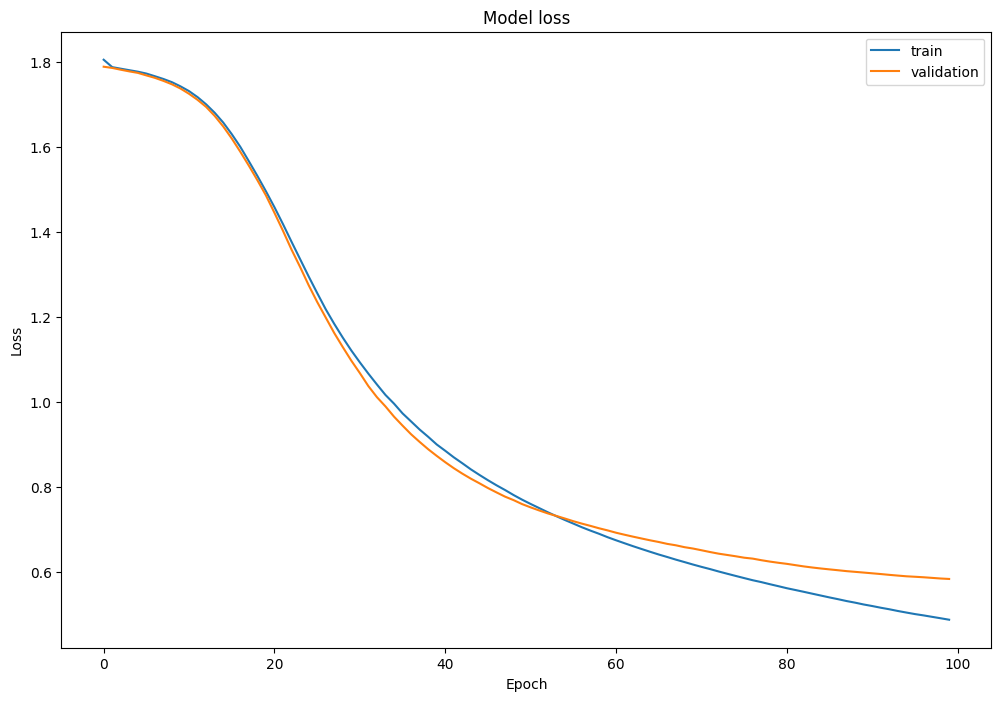

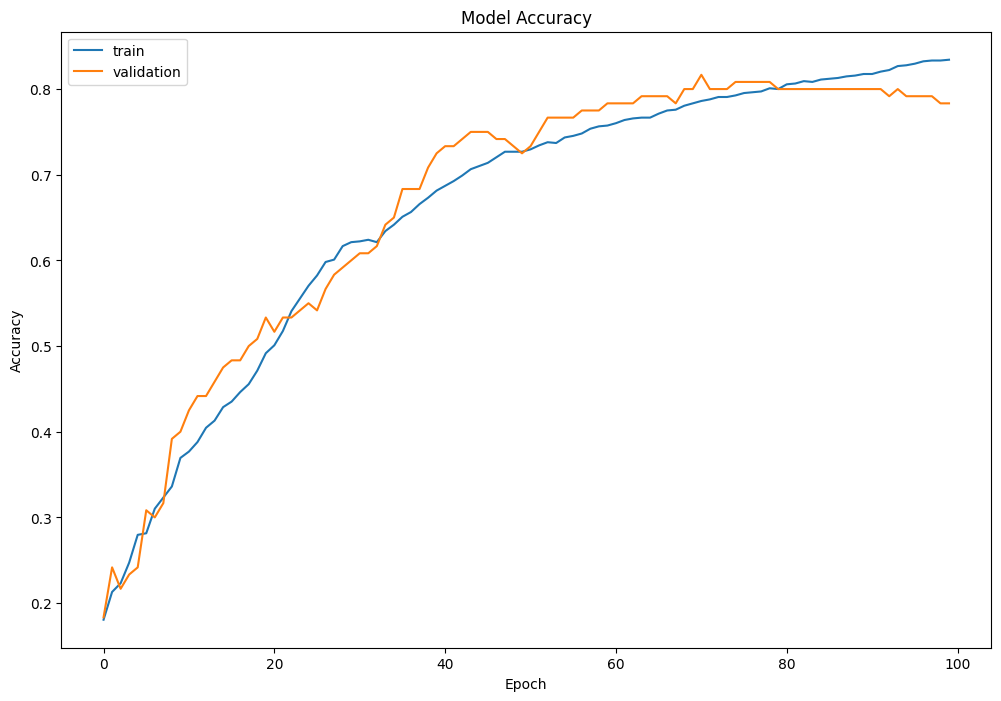

In [ ]:
# The history.history["loss"] entry is a dictionary with as many values as epochs that the
# model was trained on. 
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')